## Load and Preprocess

In [28]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [29]:
# Creates a random seed
import time
import random as rand

KERAS_SEED = int(rand.random() * time.time())
print("Seed:", KERAS_SEED)

Seed: 1644514230


In [30]:
# Read an image for size
img = cv.imread("../asl_alphabet_train/A/A1.jpg")
image_shape = img.shape

# Creates the batch size
BATCH_SIZE = 16

# Prints the image shape
image_shape

(200, 200, 3)

In [31]:
from keras import utils

# Identify the training, test, and validity data
train_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/train/",
    shuffle = True,
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

val_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/val/",
    shuffle = True,
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

test_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/test/",
    shuffle = True,
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

class_names = train_data.class_names
print(class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_data  = test_data.cache().prefetch(buffer_size = AUTOTUNE)

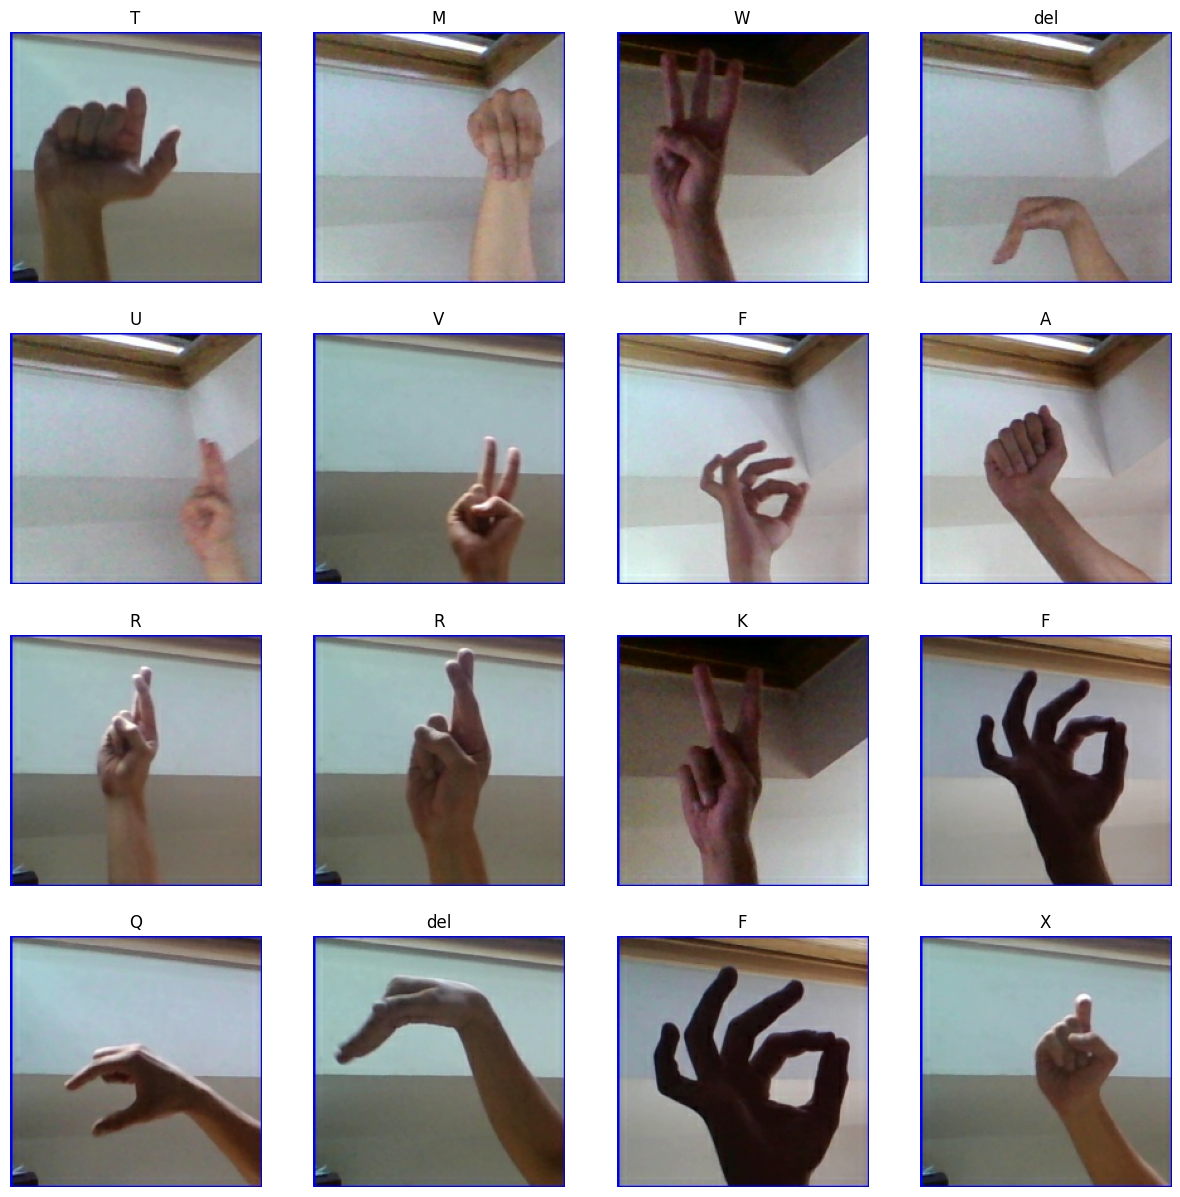

In [ ]:
plt.figure(figsize = (15, 15))

for images, labels in train_data.take(1):
    for i in range(0, BATCH_SIZE):
        plt.subplot(4, 4, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create the DCNN

In [ ]:
from keras import models
from keras import layers
from keras import applications
from keras.applications import vgg16

In [ ]:
base_layer = applications.VGG16(include_top = False, input_shape = image_shape, classifier_activation = None, classes = len(class_names), weights = "imagenet")
base_layer.trainable = False

base_layer.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
inputs = layers.Input(shape = image_shape)
x = vgg16.preprocess_input(inputs)
x = base_layer(x, False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(int(1.5 * len(class_names)), activation = "relu")(x)
outputs = layers.Dense(len(class_names), activation = "softmax")(x)

model = models.Model(inputs = inputs, outputs = outputs, name = "Ameri_Sign_Model")

model.summary()

Model: "Ameri_Sign_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 200, 200, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)          

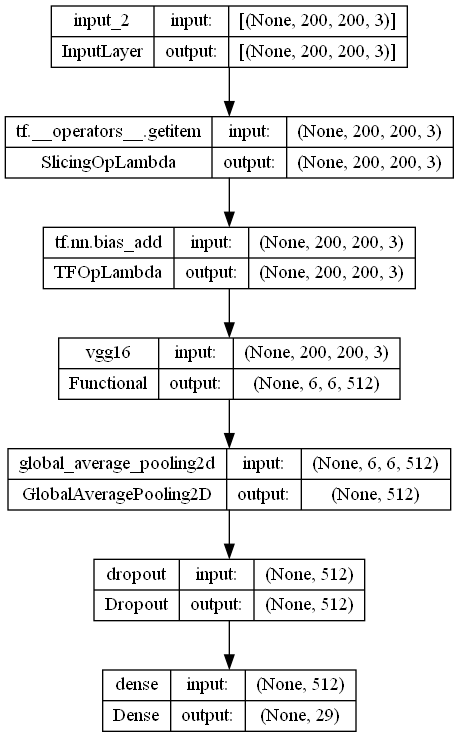

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

## Train the DCNN

In [ ]:
from keras import losses
from keras import callbacks
from keras import optimizers

# Defines the optimizer
customOptimizer = optimizers.Adam(learning_rate = 1e-3)

# Defines the loss function
customLoss      = losses.SparseCategoricalCrossentropy()

# Defines the callbacks to include
my_callbacks = [
    callbacks.ModelCheckpoint(filepath = "../Ameri Sign Models/ameri_sign_detection.acc.{epoch:02d}-{val_accuracy:.2f}.h5", monitor = "val_accuracy", mode = "max", save_best_only = True),
    #callbacks.ModelCheckpoint(filepath = "../Ameri Sign Models/Loss/mnist_detection.loss.{epoch:02d}-{val_loss:.2f}.h5", monitor = "val_loss", mode = "min", save_best_only = True),
    callbacks.EarlyStopping  (patience = 3, monitor = "accuracy"),
    #callbacks.TensorBoard    (log_dir  = "../Logs")
]

# Compile the model
model.compile(optimizer = customOptimizer, loss = customLoss, metrics = ["accuracy"],  jit_compile = None)

In [ ]:
# Trains the model
history = model.fit(train_data, epochs = 25, batch_size = BATCH_SIZE, validation_data = val_data, callbacks = my_callbacks, use_multiprocessing = True)

Epoch 1/25
4350/4350 [==============================] - 4398s 1s/step - loss: 0.5468 - accuracy: 0.8537 - val_loss: 0.0786 - val_accuracy: 0.9772
Epoch 2/25
4350/4350 [==============================] - 4419s 1s/step - loss: 0.1273 - accuracy: 0.9578 - val_loss: 0.0371 - val_accuracy: 0.9877
Epoch 3/25
4350/4350 [==============================] - 4467s 1s/step - loss: 0.1038 - accuracy: 0.9655 - val_loss: 0.0320 - val_accuracy: 0.9898
Epoch 4/25
4350/4350 [==============================] - 4485s 1s/step - loss: 0.0950 - accuracy: 0.9670 - val_loss: 0.0220 - val_accuracy: 0.9928
Epoch 5/25
4350/4350 [==============================] - 4410s 1s/step - loss: 0.0911 - accuracy: 0.9689 - val_loss: 0.0348 - val_accuracy: 0.9877
Epoch 6/25
4350/4350 [==============================] - 4456s 1s/step - loss: 0.0838 - accuracy: 0.9715 - val_loss: 0.0216 - val_accuracy: 0.9921
Epoch 7/25
4350/4350 [==============================] - 4437s 1s/step - loss: 0.0819 - accuracy: 0.9720 - val_loss: 0.0234 -

In [ ]:
# Saves the model
model.save("./model.h5")

## Evaluate the DCNN

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [33]:
def plot_history(history):
    """
    Plotting training and validation learning curves.
    @param history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label = "train")
    ax1.plot(history.history["val_loss"], label = "test")
    ax1.set_ylabel("Loss")

    # Determine upper bound of y-axis
    max_loss = max(history.history["loss"] + history.history["val_loss"])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"]) 

    # Plot accuracy
    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"],  label = "train")
    ax2.plot(history.history["val_accuracy"], label = "test")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"])

    plt.show()

In [34]:
def get_actual_predicted_labels(dataset): 
    """
    Creates a list of actual ground truth values and the predictions from the model.
    @param dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.
    @return Ground truth and predicted values for a particular dataset.
    """
    actual = []
    for _, labels in dataset:
        for ind in labels:
            actual.append(class_names[ind])

    predicted = model.predict(dataset)

    pred = []
    for labels in predicted:
        ind = tf.argmax(labels, axis = 0)
        pred.append(class_names[ind])

    return actual, pred

In [35]:
def plot_confusion_matrix(actual, predicted, labels):
    """
    Plots the confusion matrix.
    """
    matrix = confusion_matrix(y_true = actual, y_pred = predicted, labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)
    disp.plot(xticks_rotation = "vertical")
    plt.show()

In [36]:
def evaluate(dataset):
    """
    Evaluates a dataset.
    """
    # Using keras
    loss, accuracy = model.evaluate(dataset)

    # Using scikit
    actual, predicted = get_actual_predicted_labels(dataset)
    plot_confusion_matrix(actual, predicted, class_names)

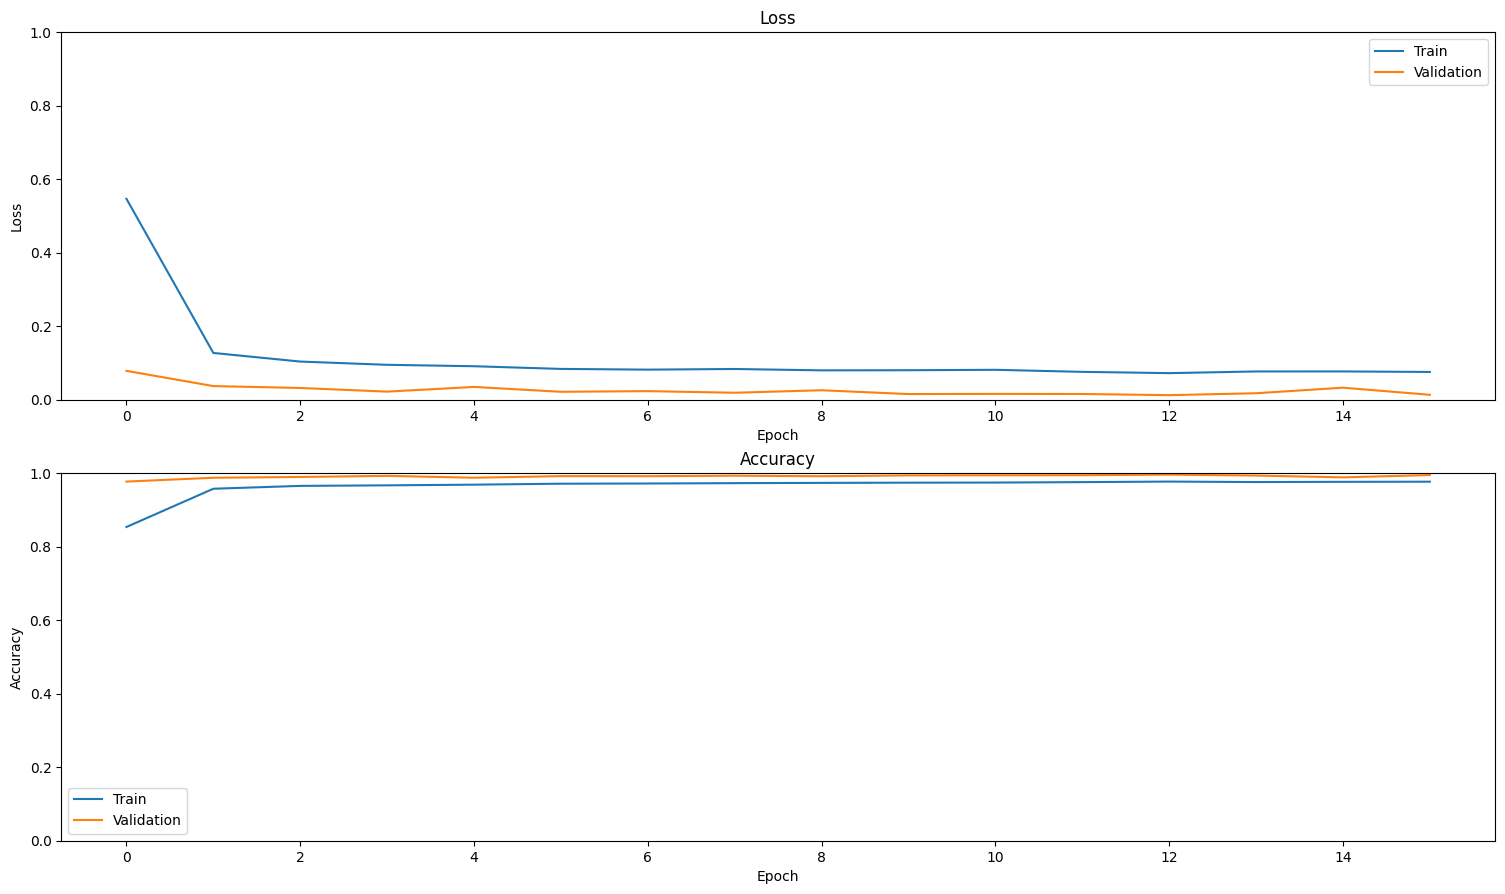

In [37]:
# Plot learning Curves
plot_history(history)

4350/4350 [==============================] - 3781s 869ms/step - loss: 0.0080 - accuracy: 0.9974
Loss: 0.01
Accuracy: 1.00
4350/4350 [==============================] - 3714s 854ms/step


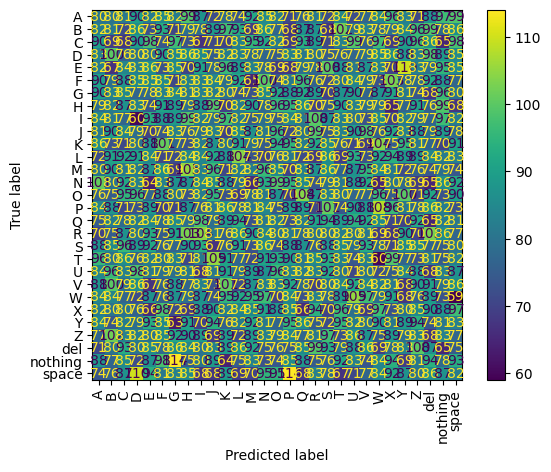

In [38]:
# Evaluate the train data
evaluate(train_data)

272/272 [==============================] - 240s 881ms/step - loss: 0.0135 - accuracy: 0.9963
Loss: 0.01
Accuracy: 1.00
272/272 [==============================] - 236s 866ms/step


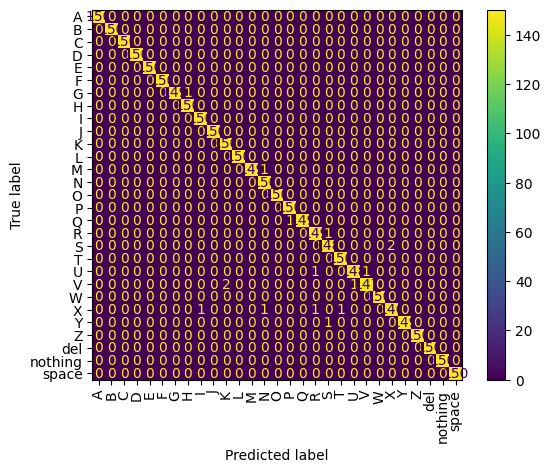

In [39]:
# Evaluate the test data
evaluate(test_data)

816/816 [==============================] - 701s 858ms/step - loss: 0.0134 - accuracy: 0.9950
Loss: 0.01
Accuracy: 1.00
816/816 [==============================] - 688s 842ms/step


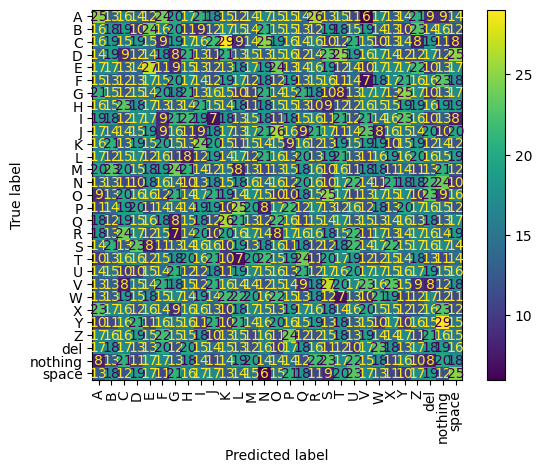

In [40]:
# Evaluate the val data
evaluate(val_data)

In [41]:
exit()

In [42]:
# Evaluate with keras
loss0, accuracy0 = model.evaluate(val_data)

816/816 [==============================] - 730s 895ms/step - loss: 0.0134 - accuracy: 0.9950


In [1]:
# Print telemetry
print("Val loss: {:.2f}".format(loss0))
print("Val accuracy: {:.2f}".format(accuracy0))

NameError: name 'loss0' is not defined

In [ ]:
# Gets the labels for the validation data
valActual, valPredicted = get_actual_predicted_labels(val_data)

816/816 [==============================] - 768s 941ms/step


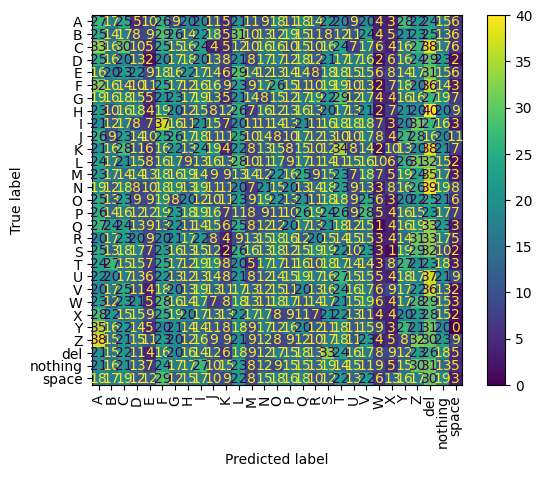

In [ ]:
# Plots the validation confusion matrix
plot_confusion_matrix(valActual, valPredicted, class_names)

In [ ]:
# Evaluate with keras
loss1, accuracy1 = model.evaluate(test_data)

272/272 [==============================] - 268s 985ms/step - loss: 2.1856 - accuracy: 0.5347


In [ ]:
# Print telemetry
print("Test loss: {:.2f}".format(loss1))
print("Test accuracy: {:.2f}".format(accuracy1))

Test loss: 2.19
Test accuracy: 0.53


In [ ]:
# Gets the labels for the test data
testActual, testPredicted = get_actual_predicted_labels(test_data)

272/272 [==============================] - 240s 882ms/step


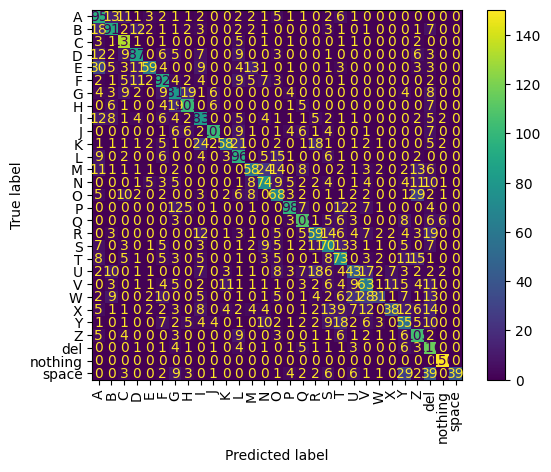

In [ ]:
# Plots the test confusion matrix
plot_confusion_matrix(testActual, testPredicted, class_names)

In [ ]:
# Evaluate with keras
loss2, accuracy2 = model.evaluate(train_data)

4350/4350 [==============================] - 3782s 868ms/step - loss: 2.1857 - accuracy: 0.5329


In [ ]:
# Print telemetry
print("Train loss: {:.2f}".format(loss2))
print("Train accuracy: {:.2f}".format(accuracy2))

Train loss: 2.19
Train accuracy: 0.53


In [ ]:
# Gets the labels for the training data
trainActual, trainPredicted = get_actual_predicted_labels(train_data)

4350/4350 [==============================] - 3716s 854ms/step


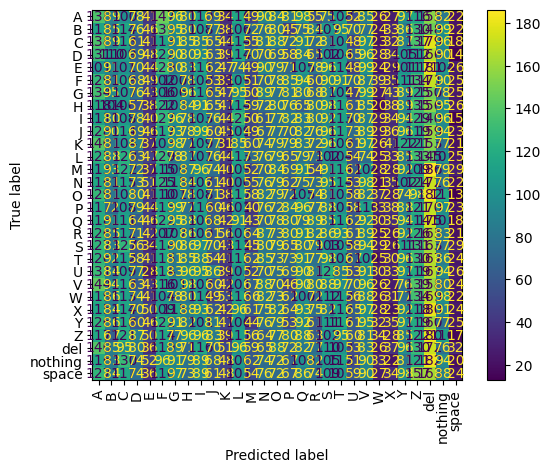

In [ ]:
# Plots the train confusion matrix
plot_confusion_matrix(trainActual, trainPredicted, class_names)